<a href="https://colab.research.google.com/github/hadisotudeh/product-color-classification/blob/main/ML%20model%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Product Color Classification

This project makes use of [FastAI](https://fast.ai) library to train a product color classifier on the [Digikala](https://digikala.com) product dataset released as part of their [data science](https://quera.ir/contest/assignments/20120/problems) competition.

In [ ]:
!git clone https://github.com/hadisotudeh/product-color-classification.git
!pip install fastai --upgrade

In [2]:
#hide
from fastai.vision.all import *
from PIL import Image

import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
train_path = Path("train")
test_path = Path("test")
split_index = 1

In [4]:
# run this cell if you are using google colab
repo_path = Path('product-color-classification')
train_path = Path.joinpath(repo_path, "train")
test_path = Path.joinpath(repo_path, "test")
split_index = 2

In [5]:
fns = get_image_files(train_path)
failed = verify_images(fns)
failed.map(train_path.unlink)

(#0) []

In [6]:
def get_color(file_path): return str(file_path).split("/")[split_index] 

dls = ImageDataLoaders.from_path_func(train_path, get_image_files(train_path), 
                                      label_func=get_color, seed=42, valid_pct=0.2,
                                      item_tfms=Resize(460), 
                                      batch_tfms=[*aug_transforms(size=224, min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                                      )

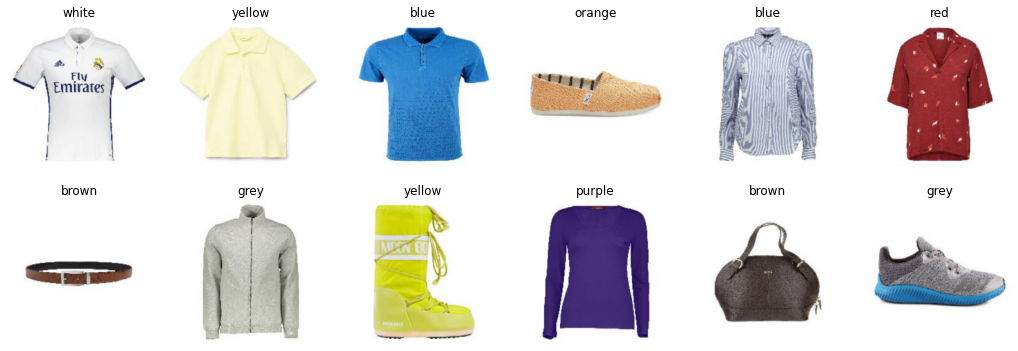

In [7]:
dls.valid.show_batch(max_n=12, nrows=2)

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


lr range is (0.004786301031708717, 0.0010000000474974513)


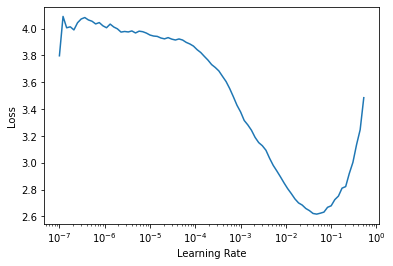

In [8]:
from fastai.callback.fp16 import *

learn = cnn_learner(dls, resnet101, metrics=accuracy).to_fp16()
lr_min, lr_steep = learn.lr_find()
print(f"lr range is ({lr_min}, {lr_steep})")

In [10]:
learn.fine_tune(12, freeze_epochs=3, base_lr=0.004)

epoch,train_loss,valid_loss,accuracy,time
0,1.541361,1.160394,0.692061,00:53
1,1.156195,0.962247,0.721732,00:53
2,0.959541,0.885976,0.750601,00:53


epoch,train_loss,valid_loss,accuracy,time
0,0.692295,0.777342,0.787490,01:03
1,0.620884,0.931062,0.739375,01:02
2,0.659196,0.892400,0.742582,01:02
3,0.624821,0.843419,0.760225,01:02
4,0.547323,0.875404,0.753809,01:02
5,0.472571,0.765397,0.795509,01:02
6,0.359834,0.781071,0.786688,01:02
7,0.259991,0.894115,0.768244,01:02
8,0.170044,0.909650,0.786688,01:02
9,0.110734,0.882743,0.797113,01:02


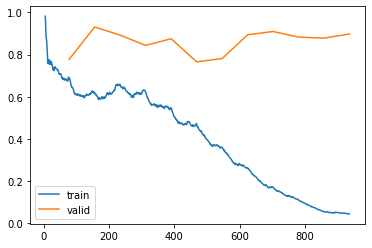

In [12]:
learn.recorder.plot_loss()

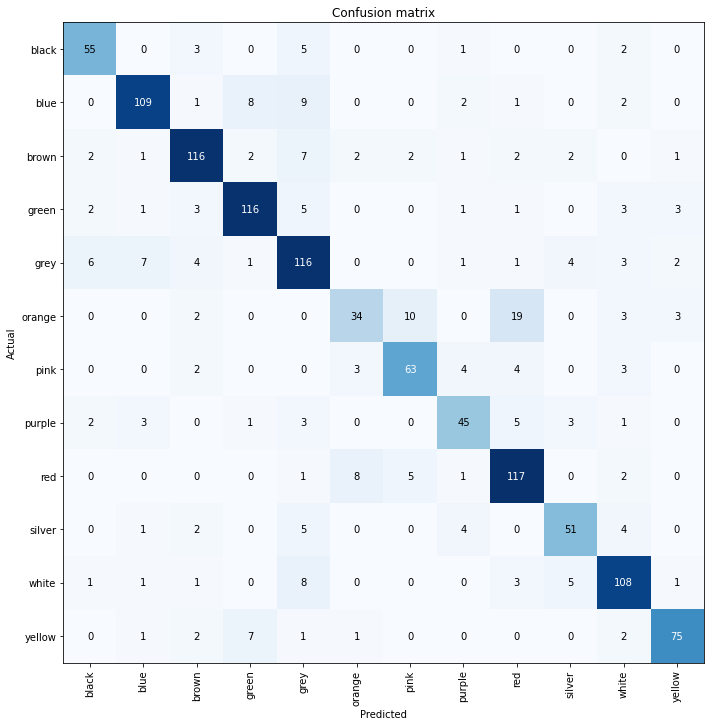

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [14]:
interp.most_confused(5)

[('orange', 'red', 19),
 ('orange', 'pink', 10),
 ('blue', 'grey', 9),
 ('blue', 'green', 8),
 ('red', 'orange', 8),
 ('white', 'grey', 8),
 ('brown', 'grey', 7),
 ('grey', 'blue', 7),
 ('yellow', 'green', 7),
 ('grey', 'black', 6),
 ('black', 'grey', 5),
 ('green', 'grey', 5),
 ('purple', 'red', 5),
 ('red', 'pink', 5),
 ('silver', 'grey', 5),
 ('white', 'silver', 5)]

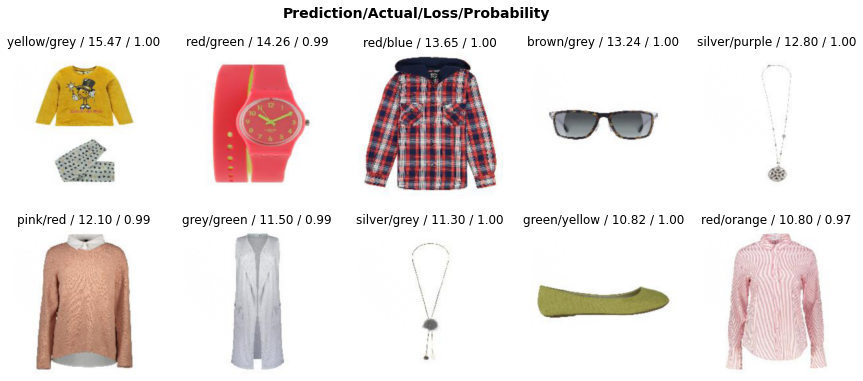

In [15]:
interp.plot_top_losses(10, bnrows=2)

In [35]:
import os
exported_model_path = os.path.abspath('export.pkl')
learn.export(exported_model_path)

In [36]:
learn = load_learner(exported_model_path)

In [51]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()

btn_run = widgets.Button(description='Classify')

lbl_pred = widgets.Label()
out_pl = widgets.Output()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])

    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))

    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
VBox([widgets.Label("Select your product!"), btn_upload, btn_run, out_pl, lbl_pred])